# 집 값 예측하기 실습


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

2023-06-15 00:18:49.115677: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 00:18:49.174917: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 00:18:49.175807: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 00:18:50.002822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
data = pd.read_csv("../data/house_price-train.csv")
data.shape

(1460, 81)

비 수치형 데이터를 인코딩하여 수치형으로 바꿔줍니다.

In [12]:
non_numeric_columns = data.select_dtypes(exclude=np.number).columns
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for i in non_numeric_columns:
    data[i] = label_encoder.fit_transform(data[i])

수치형 데이터를 정규화 해줍니다.

In [16]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
numeric_columns = data.select_dtypes(['int64', 'float64']).columns
data[numeric_columns] = min_max_scaler.fit_transform(data[numeric_columns])
display(data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.000000,0.235294,0.75,0.150685,0.033420,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.00000,0.090909,0.50,1.0,0.8,0.241078
1,0.000685,0.000000,0.75,0.202055,0.038795,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.00000,0.363636,0.25,1.0,0.8,0.203583
2,0.001371,0.235294,0.75,0.160959,0.046507,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.00000,0.727273,0.50,1.0,0.8,0.261908
3,0.002056,0.294118,0.75,0.133562,0.038561,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.00000,0.090909,0.00,1.0,0.0,0.145952
4,0.002742,0.235294,0.75,0.215753,0.060576,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.00000,1.000000,0.50,1.0,0.8,0.298709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.997258,0.235294,0.75,0.140411,0.030929,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.00000,0.636364,0.25,1.0,0.8,0.194556
1456,0.997944,0.000000,0.75,0.219178,0.055505,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.5,1.0,0.00000,0.090909,1.00,1.0,0.8,0.243161
1457,0.998629,0.294118,0.75,0.154110,0.036187,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.5,0.16129,0.363636,1.00,1.0,0.8,0.321622
1458,0.999315,0.000000,0.75,0.160959,0.039342,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.00000,0.272727,1.00,1.0,0.8,0.148903


변수들간의 상관관계를 분석합니다.
독립변수들간에 상관관계가 높으면 중복해서 입력하는 효과가 있기 때문에 데이터를 사용하기 전에 데이터가 정규분포를 따르는지와 더붙어 상관관게 분석을 통해 같이 쓰지 말아야 할 독립 변수들을 파악하고 있는 것이 좋습니다.
아래 코드는 우리가 예측하고자 하는 종속변수인 집값과의 상관계수를 구한 것으로써 이 경우에는 사실 경우에 따라 포함하여야 할지 특정 변수를 뺴야할지 달라질 수 있습니다. 너무 대부분의 독립변수들이 높은 상관관계를 가지게 되면 정답을 뻔하게 알게되고 데이터간 새로운 패턴이나 유의미함을 알 수 없기 떄문입니다.

In [19]:
np.abs(data[numeric_columns].corr().loc[:,"SalePrice"]).sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
ExterQual       0.636884
                  ...   
Utilities       0.014314
BsmtFinSF2      0.011378
BsmtFinType2    0.008041
Condition2      0.007513
GarageQual      0.006861
Name: SalePrice, Length: 80, dtype: float64

데이터 중에 입력되지 않은 값이나 Nan값이 있는지 확인합니다.

In [22]:
missing_values = data.isnull().sum().sort_values(ascending=False)
print(missing_values)

LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
Id                0
KitchenAbvGr      0
               ... 
ExterQual         0
MasVnrType        0
Exterior2nd       0
Exterior1st       0
SalePrice         0
Length: 81, dtype: int64


직접 Nan이나 빈값, inf값 등등 값들을 포함하는 레코드를 지워도 되지만, 이 예제에서는 빠른 실행을 위해 통째로 특정 컬럼을  제외하고 학습 데이터로 집어 넣겠습니다.

In [40]:
data_filtered = data.loc[:, ~data.columns.isin(['LotFrontage', 'GarageYrBlt', 'MasVnrArea'])]

In [41]:
from sklearn.linear_model import LinearRegression

x_train = data_filtered.to_numpy(dtype=np.float32)[:1000, :-1]
y_train = data_filtered.to_numpy(dtype=np.float32)[:1000, -1]

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

score = 0.7085861918395759


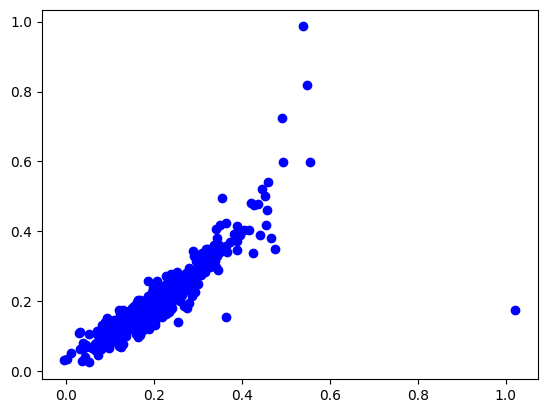

In [58]:
x_test = data_filtered.to_numpy(dtype=np.float32)[1000:, :-1]
y_test = data_filtered.to_numpy(dtype=np.float32)[1000:, -1, np.newaxis]

y_predict = model.predict(x_test)

score = model.score(x_test, y_test)
print(f"score = {score}")

plt.scatter(y_predict, y_test, c='b') # bwr : 파랑-흰색-빨강 색상맵